<a href="https://colab.research.google.com/github/SusheelThapa/ML-From-Scratch/blob/tfProject/tensorflow/projects/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and Dog classifier

For this challenge, We will complete the code to classify images of dogs and cats. We will use TensorFlow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time.


## Importing the necessary package

We will be loading all the package that we need during cat and dog classification.

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Retrieving the dataset

We will retrieve the images of cat and dog via CDN(Content Delivery Network) link and store it locally.

Then, we will create a variable to store path to the respective directory.

In [2]:
# # Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2023-05-10 01:08:45--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   129MB/s    in 0.5s    

2023-05-10 01:08:46 (129 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Creating Image generator

*ImageDataGenerator* class in Keras is used for implementing **image augmentation**. It is used to generate batches of tensor image data with real-time data augmentation.

Here, we are using *ImageDataGenerator* to create batch of image for train, validation and testing.

You can know more about from [official page](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [30]:
# Creating image data generator
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Loading respective image in batch from respective dir
train_data_gen = train_image_generator.flow_from_directory(
                                        directory=train_dir,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        color_mode="rgb",
                                        batch_size=batch_size,
                                        class_mode="binary",
                                        shuffle=True,
                                        seed=42
                                        )
val_data_gen = validation_image_generator.flow_from_directory(
                                        directory=validation_dir,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        color_mode="rgb",
                                        batch_size=batch_size,
                                        class_mode="binary",
                                        shuffle=True,
                                        seed=42
                                        )
test_data_gen = test_image_generator.flow_from_directory(
                                        directory=PATH,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        color_mode="rgb",
                                        batch_size=batch_size,
                                        classes=['test'],
                                        shuffle=False,
                                        seed=42
                                        )
     

### Plotting the images

In this section, a function `plotImages()` has been provided to plot the image that is loaded

In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


### Building the model

#### Data Preprocessing

Before start building the model, we are again creating out `train_image_generator` which is same as above cell

In [5]:
# Same as above + addition of transformation arguments
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


Since, we have few training examples so we will augument the image to create more training sets.

In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

#### Creating model

We will start by creating convolutional base and then dense connecting layer.

In [45]:
# Creating the sequential model
model = Sequential()

# Convolutional Base Layer
model.add(Conv2D(256,(3,3),activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

# Dense Connecting layer
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))

# Output layer
model.add(Dense(1,activation='sigmoid')) # Classification problem so no. of node is 1 and activation function is sigmoid

# Compile the model with binary_crossentropy loss as it is problem of classification of 2 classes
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

# Summarizing the model
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 148, 148, 256)     7168      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 74, 74, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 72, 72, 128)       295040    
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 34, 34, 64)        73792     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 17, 17, 64)     

#### Training the model

We will be training the model with training data set and validation data set.

In [46]:
# Calculating the step size
step_size_train = train_data_gen.n//train_data_gen.batch_size
step_size_valid = val_data_gen.n//val_data_gen.batch_size

# Training the model
history = model.fit(
    train_data_gen, 
    epochs=epochs,
    steps_per_epoch=step_size_train,
    validation_data = val_data_gen,
    validation_steps=step_size_valid,
    )

Epoch 1/15
15/15 [==============================] - 35s 2s/step - loss: 0.6949 - accuracy: 0.4952 - val_loss: 0.6933 - val_accuracy: 0.5045
Epoch 2/15
15/15 [==============================] - 21s 1s/step - loss: 0.6931 - accuracy: 0.5091 - val_loss: 0.6920 - val_accuracy: 0.5614
Epoch 3/15
15/15 [==============================] - 21s 1s/step - loss: 0.6939 - accuracy: 0.4877 - val_loss: 0.6926 - val_accuracy: 0.5346
Epoch 4/15
15/15 [==============================] - 21s 1s/step - loss: 0.6930 - accuracy: 0.5032 - val_loss: 0.6917 - val_accuracy: 0.5357
Epoch 5/15
15/15 [==============================] - 21s 1s/step - loss: 0.6934 - accuracy: 0.5096 - val_loss: 0.6885 - val_accuracy: 0.5536
Epoch 6/15
15/15 [==============================] - 20s 1s/step - loss: 0.6936 - accuracy: 0.5085 - val_loss: 0.6900 - val_accuracy: 0.5190
Epoch 7/15
15/15 [==============================] - 20s 1s/step - loss: 0.6918 - accuracy: 0.5379 - val_loss: 0.6885 - val_accuracy: 0.5804
Epoch 8/15
15/15 [==

### Visualization of accuracy and loss

We will be looking into the graph which show the accuracy and loss of training dataset and validation dataset

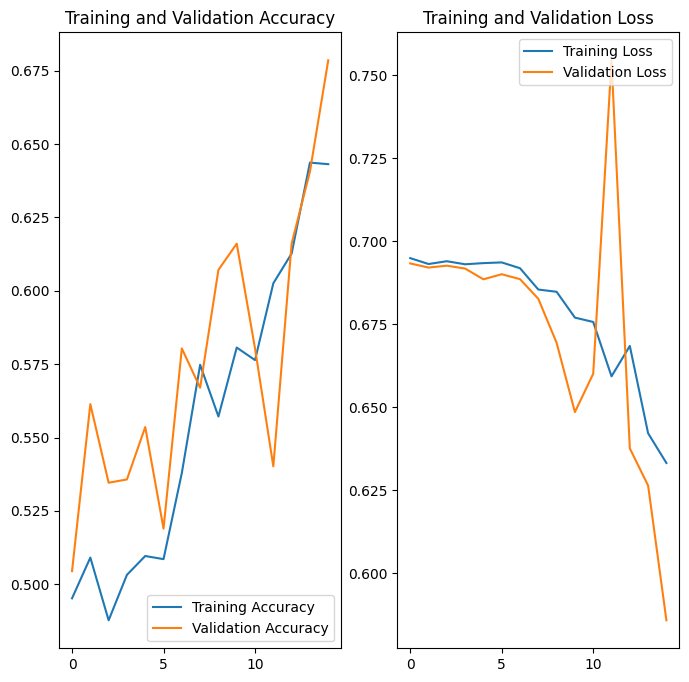

In [47]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prediction via model

We will use of model we have created to predict the test data set and find out respective prediction.

You can find more about `predict` method from [official page](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)

1/1 [==============================] - 1s 1s/step


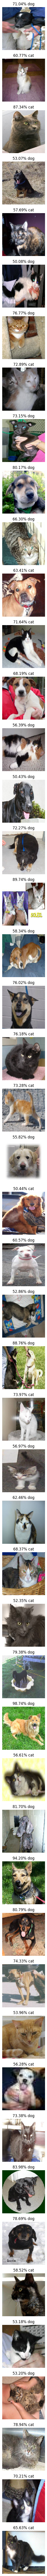

In [48]:
# Predicting and convert the probability given by model to suitable form

probabilities = model.predict(test_data_gen) # return the prediction of image in numpy 2D array(one of the dimension is 1 i.e. M * 1)

probabilities = probabilities.reshape(-1) # convert the numpy 2D array into 1D array

probabilities = probabilities.tolist()# convert numpy 1D array into list as below cell require data in this format

sample_testing_images, _ = next(test_data_gen)
plotImages(sample_testing_images, probabilities = probabilities)

### Free Code Camp Testing our model

In [49]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
